# Gaussian Random Path

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Done.")

Done.


### Util

In [2]:
def kernel_se(X1,X2,hyp={'g':1,'l':1}):
    """
        Squared exponential (SE) kernel function
    """
    K = hyp['g']*np.exp(-cdist(X1,X2,'sqeuclidean')/(2*hyp['l']*hyp['l']))
    return K

def kernel_levse(X1,X2,L1,L2,hyp={'g':1,'l':1}):
    """
        Leveraged SE kernel function
    """
    K = hyp['g']*np.exp(-cdist(X1,X2,'sqeuclidean')/(2*hyp['l']*hyp['l']))
    L = np.cos(np.pi/2.0*cdist(L1,L2,'cityblock'))
    return np.multiply(K,L)

def soft_squash(x,x_min=-1,x_max=+1,margin=1.0):
    """
        Soft squashing numpy array
    """
    def th(z,m=0.0):
        # thresholding function 
        return (m)*(np.exp(2/m*z)-1)/(np.exp(2/m*z)+1)
    x_in = np.copy(x)
    idxs_upper = np.where(x_in>(x_max-margin))
    x_in[idxs_upper] = th(x_in[idxs_upper]-(x_max-margin),m=margin) + (x_max-margin)
    idxs_lower = np.where(x_in<(x_min+margin))
    x_in[idxs_lower] = th(x_in[idxs_lower]-(x_min+margin),m=margin) + (x_min+margin)
    return x_in
print ("Done.")

Done.


### Plot how 'soft_squash' works

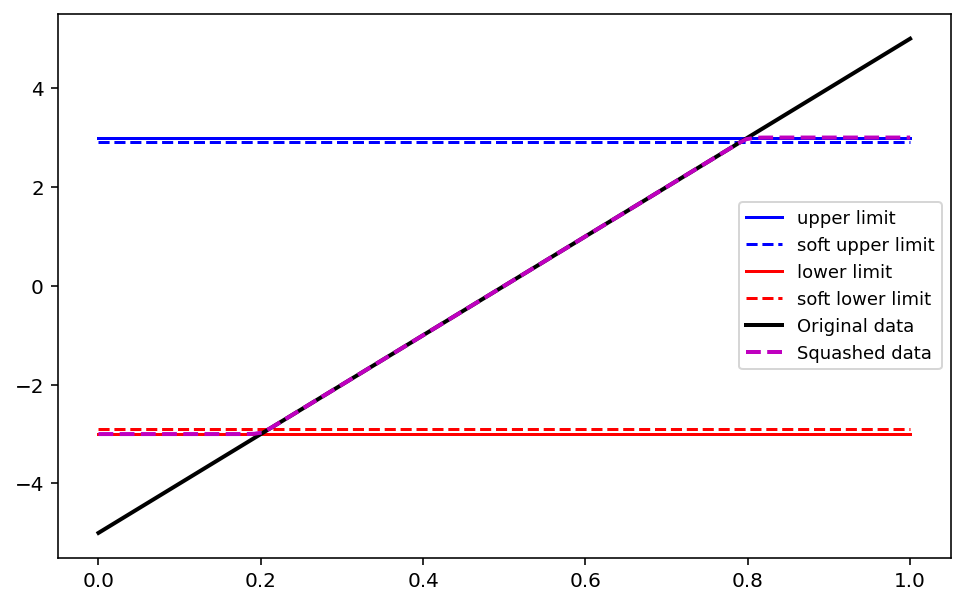

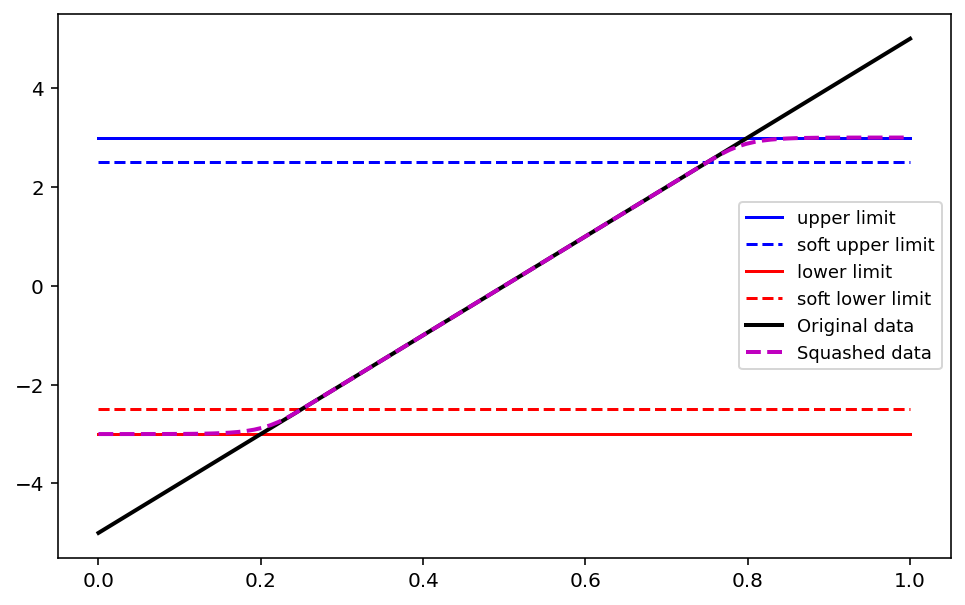

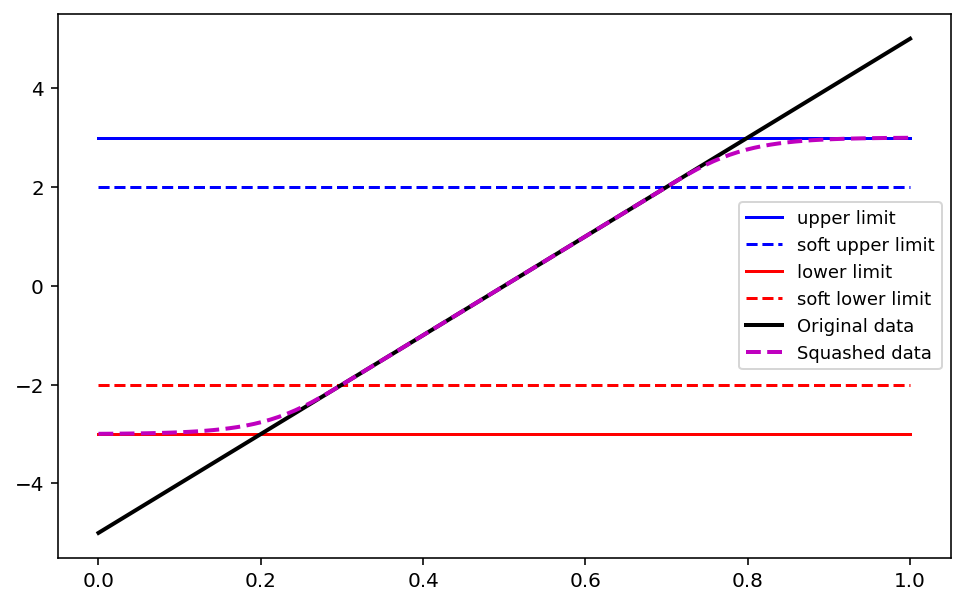

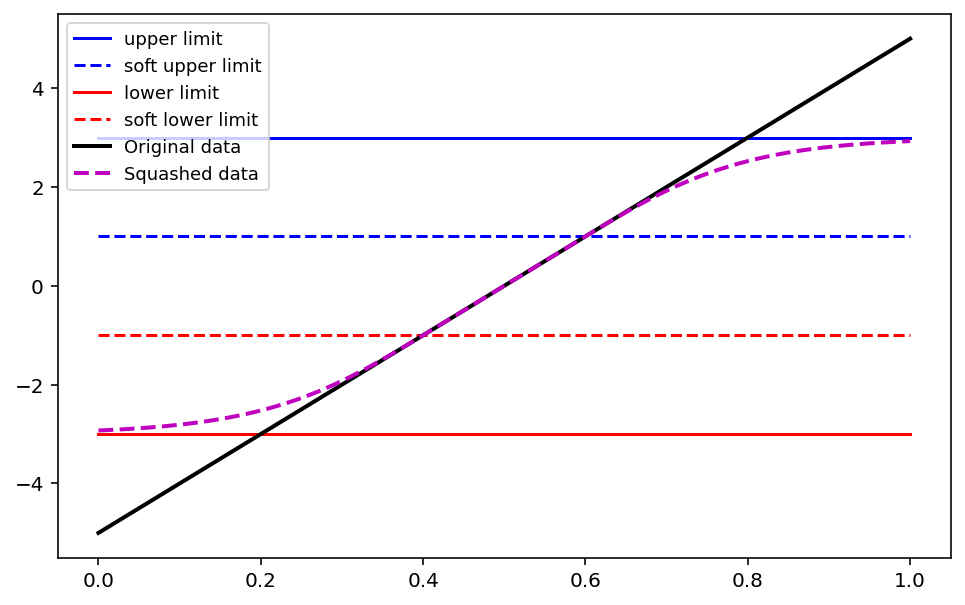

In [3]:
t = np.linspace(0,1,100).reshape((-1,1))
x = np.linspace(-5,+5,100).reshape((-1,1))

margins = [0.1,0.5,1.0,2.0]
for margin in margins:
    x_min,x_max,margin = -3,3,margin
    x_squash = soft_squash(x,x_min=x_min,x_max=x_max,margin=margin)
    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(t,x_max*np.ones_like(t),color='b',label='upper limit')
    plt.plot(t,(x_max-margin)*np.ones_like(t),'--',color='b',label='soft upper limit')
    plt.plot(t,x_min*np.ones_like(t),'-',color='r',label='lower limit')
    plt.plot(t,(x_min+margin)*np.ones_like(t),'--',color='r',label='soft lower limit')
    plt.plot(t,x,'-',color='k',lw=2,label='Original data')
    plt.plot(t,x_squash,'--',color='m',lw=2,label='Squashed data')
    plt.legend(fontsize=9)
    plt.show()

### Gaussian Random Path Class

In [4]:
class GaussianRandomPathClass(object):
    def __init__(self,
                 name     = 'GRP',
                 kernel   = kernel_levse,
                 hyp_mean = {'g':1.0,'l':1.0,'w':1e-6},
                 hyp_var  = {'g':1.0,'l':1.0,'w':1e-6}
                 ):
        super(GaussianRandomPathClass,self).__init__()
        self.name = name
        # Set kernel
        self.kernel   = kernel     # kernel function
        self.hyp_mean = hyp_mean
        self.hyp_var  = hyp_var
        # Default set data
        self.set_data()
        
    def set_data(self,
                 t_anchor     = np.linspace(start=0.0,stop=1.0,num=10).reshape((-1,1)),
                 x_anchor     = np.zeros((10,2)),
                 l_anchor     = np.ones((10,1)),
                 t_test       = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
                 l_test       = np.ones((100,1)),
                 hyp_mean     = None,
                 hyp_var      = None,
                 w_chol       = 1e-10,     # noise for Cholesky transform
                 APPLY_EPSRU  = False,     # epsilon run-up
                 t_eps        = 0.0001,
                 l_eps        = 1.0,       # leverage for epsilon run-up
                 x_diff_start = None,
                 x_diff_end   = None,
                 SKIP_GP_VAR  = False      # skip GP variance computation
                 ):
        """
            Set anchor data to GRP class
        """
        self.t_anchor    = t_anchor.astype(float)    # [N x 1]
        self.x_anchor    = x_anchor.astype(float)    # [N x D]
        self.t_test      = t_test.astype(float)      # [N_test x 1]
        self.n_anchor    = self.x_anchor.shape[0]
        self.d_anchor    = self.x_anchor.shape[1]
        self.l_anchor    = l_anchor.astype(float)    # [N x 1]
        self.n_test      = self.t_test.shape[0]
        self.l_test      = l_test.astype(float)      # [N_test x 1]
        if hyp_mean is not None: self.hyp_mean = hyp_mean
        if hyp_var is not None: self.hyp_var = hyp_var
            
        # Handle epsilon greedy algorithm
        self.APPLY_EPSRU = APPLY_EPSRU
        self.t_eps       = t_eps
        if self.APPLY_EPSRU:
            # Append runup points
            if (x_diff_start is not None) and (x_diff_end is not None):
                self.x_diff_start = x_diff_start
                self.x_diff_end   = x_diff_end
            else:
                self.x_diff_start = (self.x_anchor[-1,:]-self.x_anchor[0,:]).reshape((1,-1))
                self.x_diff_end = (self.x_anchor[-1,:]-self.x_anchor[0,:]).reshape((1,-1))
            self.t_dur  = (self.t_anchor[-1]-self.t_anchor[0]).squeeze()
            # Append 'x_anchor'
            x_anchor    = self.x_anchor
            x_anchor    = np.insert(x_anchor,1,
                                    x_anchor[0,:]+self.t_eps/self.t_dur*self.x_diff_start,axis=0)
            x_anchor    = np.insert(x_anchor,-1,
                                    x_anchor[-1,:]-self.t_eps/self.t_dur*self.x_diff_end,axis=0)
            n_anchor    = self.x_anchor.shape[0]
            # Append 'x_anchor'
            t_anchor    = self.t_anchor
            t_anchor    = np.insert(t_anchor,1,t_anchor[0,:]+self.t_eps,axis=0)
            t_anchor    = np.insert(t_anchor,-1,t_anchor[-1,:]-self.t_eps,axis=0)
            # Append 'l_anchor'
            l_anchor    = self.l_anchor
            l_eps       = 0.0
            l_anchor    = np.insert(l_anchor,1,l_eps,axis=0)
            l_anchor    = np.insert(l_anchor,-1,l_eps,axis=0)
            # Overwrite 'x_anchor', 't_anchor', 'l_anchor', and 'n_anchor'
            self.x_anchor = x_anchor
            self.t_anchor = t_anchor
            self.n_anchor = self.x_anchor.shape[0]
            if self.kernel.__name__ == 'kernel_levse': # leveraged SE kernel
                self.l_anchor = l_anchor
                
        # GP mean-related
        if self.kernel.__name__ == 'kernel_levse': # leveraged SE kernel
            l_anchor_mean = np.ones((self.n_anchor,1)) # leverage does not affect GP mean
            self.k_test_anchor_mean   = self.kernel(self.t_test,self.t_anchor,
                                                    self.l_test,l_anchor_mean,
                                                    self.hyp_mean)
            self.K_anchor_anchor_mean = self.kernel(self.t_anchor,self.t_anchor,
                                                    l_anchor_mean,l_anchor_mean,
                                                    self.hyp_mean) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        elif self.kernel.__name__ == 'kernel_se': # SE kernel
            self.k_test_anchor_mean   = self.kernel(self.t_test,self.t_anchor,
                                                    self.hyp_mean)
            self.K_anchor_anchor_mean = self.kernel(self.t_anchor,self.t_anchor,
                                                    self.hyp_mean) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        else:
            raise TypeError("[GaussianRandomPathClass] Unsupported kernel:[%s]"%
                            (self.kernel.__name__))
        self.x_anchor_mean        = self.x_anchor.mean(axis=0)
        self.gamma_test           = np.linalg.solve(self.K_anchor_anchor_mean,
                                                    self.x_anchor-self.x_anchor_mean)
        self.mean_test            = np.matmul(self.k_test_anchor_mean,self.gamma_test) \
                                    + self.x_anchor_mean
        
        # GP variance-related
        self.SKIP_GP_VAR = SKIP_GP_VAR
        if self.SKIP_GP_VAR: return # skip in case of computing the mean only 
        if self.kernel.__name__ == 'kernel_levse': # leveraged SE kernel
            self.k_test_test_var     = self.kernel(self.t_test,self.t_test,
                                                   self.l_test,self.l_test,
                                                   self.hyp_var)
            self.k_test_anchor_var   = self.kernel(self.t_test,self.t_anchor,
                                                   self.l_test,self.l_anchor,
                                                   self.hyp_var)
            self.K_anchor_anchor_var = self.kernel(self.t_anchor,self.t_anchor,
                                                   self.l_anchor,self.l_anchor,
                                                   self.hyp_var) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        elif self.kernel.__name__ == 'kernel_se': # SE kernel
            self.k_test_test_var     = self.kernel(self.t_test,self.t_test,
                                                   self.hyp_var)
            self.k_test_anchor_var   = self.kernel(self.t_test,self.t_anchor,
                                                   self.hyp_var)
            self.K_anchor_anchor_var = self.kernel(self.t_anchor,self.t_anchor,
                                                   self.hyp_var) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        else:
            raise TypeError("[GaussianRandomPathClass] Unsupported kernel:[%s]"%
                            (self.kernel.__name__))
        self.var_test            = self.k_test_test_var - np.matmul(self.k_test_anchor_var,
            np.linalg.solve(self.K_anchor_anchor_var,self.k_test_anchor_var.T))
        self.var_diag_test       = np.diag(self.var_test).reshape((-1,1))
        self.std_diag_test       = np.sqrt(self.var_diag_test)
        self.w_chol              = w_chol
        self.var_chol_test       = np.linalg.cholesky(self.var_test \
                                                      + self.w_chol*np.eye(self.n_test))
            
    def sample(self,
               n_sample  = 10,
               rand_type = 'Gaussian'):
        """
            Sample from GRP
        """
        samples = []
        for s_idx in range(n_sample):
            if rand_type == 'Gaussian':
                R = np.random.randn(self.n_test,self.d_anchor)
            elif rand_type == 'Uniform':
                rand_gain = 3 # -gain ~ +gain
                R = rand_gain*(2*np.random.rand(self.n_test,self.d_anchor)-1)
            else:
                raise TypeError("[GaussianRandomPathClass] Unsupported rand_type:[%s]"%(rand_type))
            sample = self.mean_test+np.matmul(self.var_chol_test,R)
            samples.append(sample)
        return samples,self.t_test
    
    def plot(self,
             n_sample  = 10,
             figsize   = (6,3),
             lw_sample = 1/4,
             ylim      = None,
             title_str = None,
             tfs       = 15,
             rand_type = 'Gaussian'):
        """
            Plot GRP
        """
        sampled_trajs,t_test = self.sample(n_sample=n_sample,rand_type=rand_type)
        colors = [plt.cm.Set1(i) for i in range(self.d_anchor)]
        for d_idx in range(self.d_anchor):
            color = colors[d_idx]
            plt.figure(figsize=figsize)
            # Plot sampled trajectories
            for s_idx in range(len(sampled_trajs)):
                sampled_traj = sampled_trajs[s_idx]
                plt.plot(self.t_test,sampled_traj[:,d_idx],'-',color='k',lw=lw_sample)
            # Plot mean
            plt.plot(self.t_test,self.mean_test[:,d_idx],'-',color=color,lw=3)
            # Plot anchors
            plt.plot(self.t_anchor,self.x_anchor[:,d_idx],'o',mfc='none',ms=10,mec='k')
            # Plot 2-standard deviation (95%)
            plt.fill_between(self.t_test.squeeze(),
                             self.mean_test[:,d_idx]-2*self.std_diag_test.squeeze(),
                             self.mean_test[:,d_idx]+2*self.std_diag_test.squeeze(),
                             facecolor=color,interpolate=True,alpha=0.2)
            if ylim is not None:
                plt.ylim(ylim)
            if title_str is None:
                plt.title("Dim-[%d]"%(d_idx),fontsize=tfs)
            else:
                plt.title("%s"%(title_str),fontsize=tfs)
            plt.show()
print ("Done.")

Done.


### Instantiate GRP

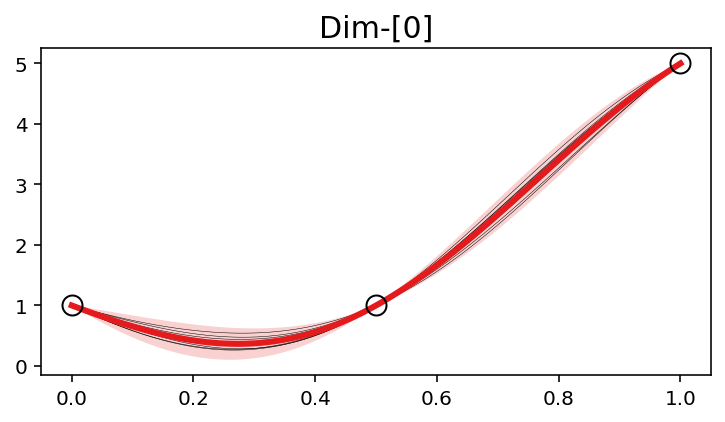

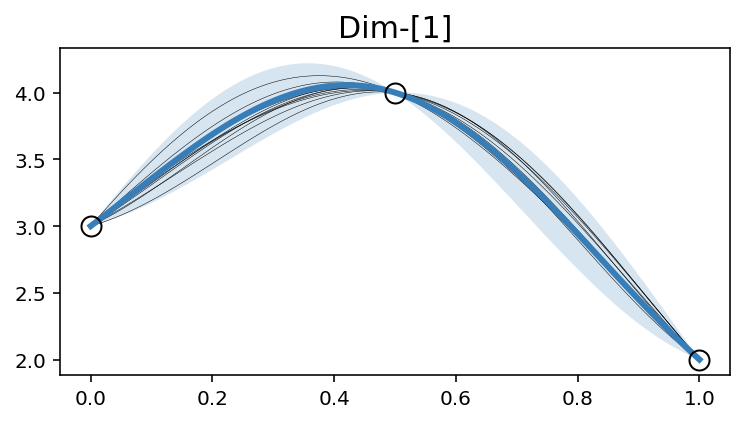

[GRP] ready.


In [5]:
G = GaussianRandomPathClass(name = 'GRP',kernel = kernel_se)
G.set_data(t_anchor    = np.linspace(start=0.0,stop=1.0,num=3).reshape((-1,1)),
           x_anchor    = np.array([[1,1,5],[3,4,2]]).T,
           t_test      = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
           hyp_mean    = {'g':1.0,'l':0.5,'w':1e-6},
           hyp_var     = {'g':1.0,'l':0.5,'w':1e-6},
           APPLY_EPSRU = False
          )
G.plot(n_sample=10)
print ("[%s] ready."%(G.name))

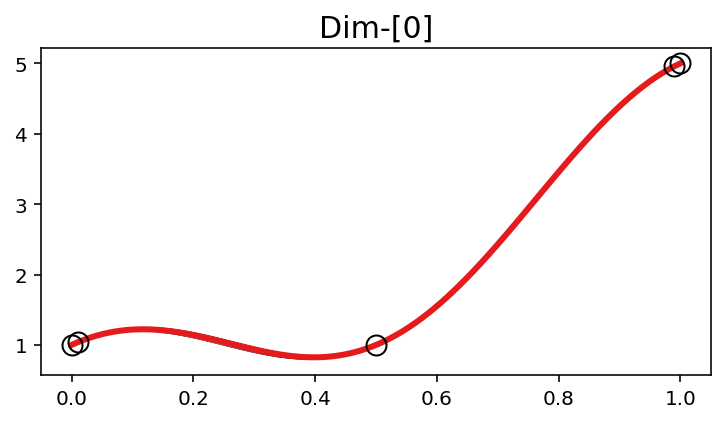

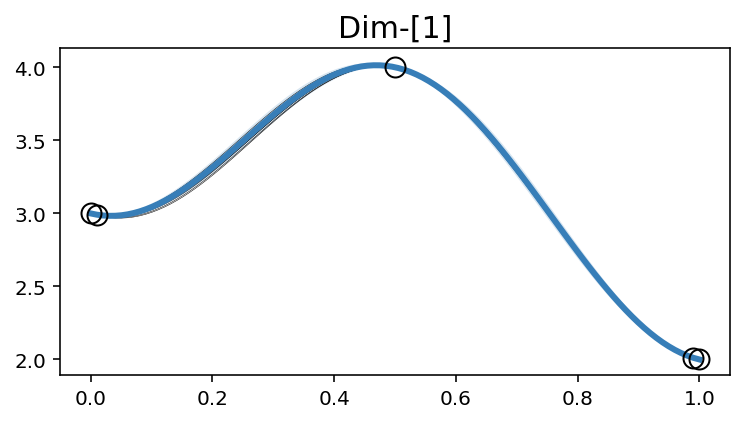

[GRP] ready.


In [6]:
G = GaussianRandomPathClass(name = 'GRP',kernel = kernel_se)
G.set_data(t_anchor    = np.linspace(start=0.0,stop=1.0,num=3).reshape((-1,1)),
           x_anchor    = np.array([[1,1,5],[3,4,2]]).T,
           t_test      = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
           hyp_mean    = {'g':1.0,'l':0.5,'w':1e-6},
           hyp_var     = {'g':1.0,'l':0.5,'w':1e-6},
           APPLY_EPSRU = True,
           t_eps       = 1e-2
          )
G.plot(n_sample=10)
print ("[%s] ready."%(G.name))

### Instantiate Leveraged GRP

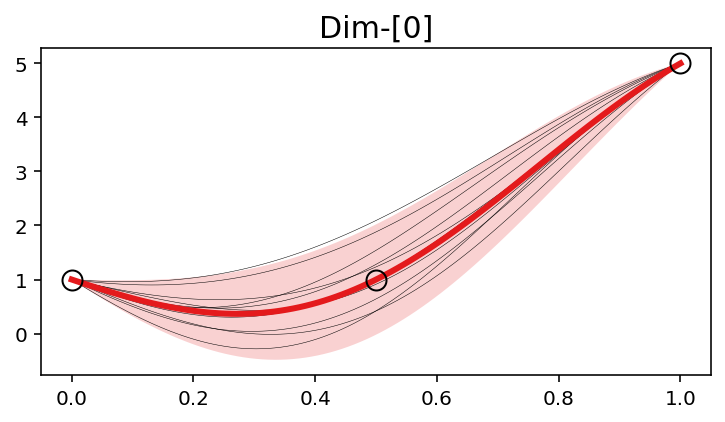

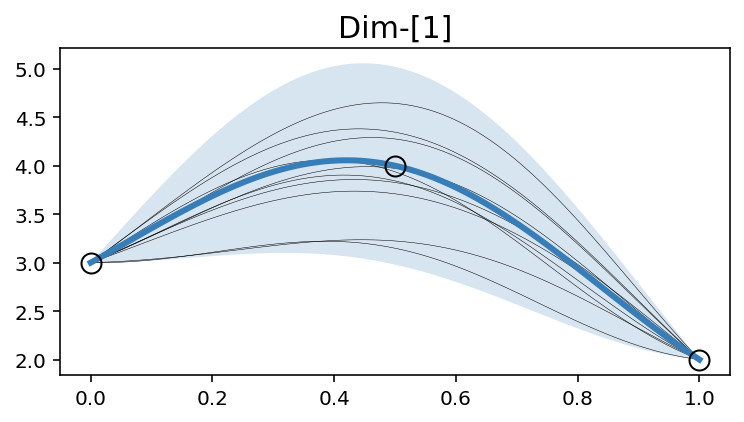

[LGRP] ready.


In [7]:
G = GaussianRandomPathClass(name = 'LGRP',kernel = kernel_levse)
G.set_data(t_anchor    = np.linspace(start=0.0,stop=1.0,num=3).reshape((-1,1)),
           x_anchor    = np.array([[1,1,5],[3,4,2]]).T,
           l_anchor    = np.array([[1,0.5,1]]).T,
           t_test      = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
           l_test      = np.ones((100,1)),
           hyp_mean    = {'g':1.0,'l':0.5,'w':1e-6},
           hyp_var     = {'g':1.0,'l':0.5,'w':1e-6},
           APPLY_EPSRU = False
          )
G.plot(n_sample=10)
print ("[%s] ready."%(G.name))

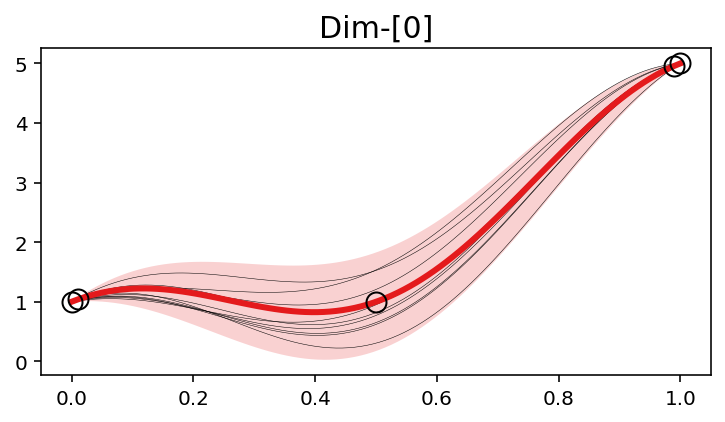

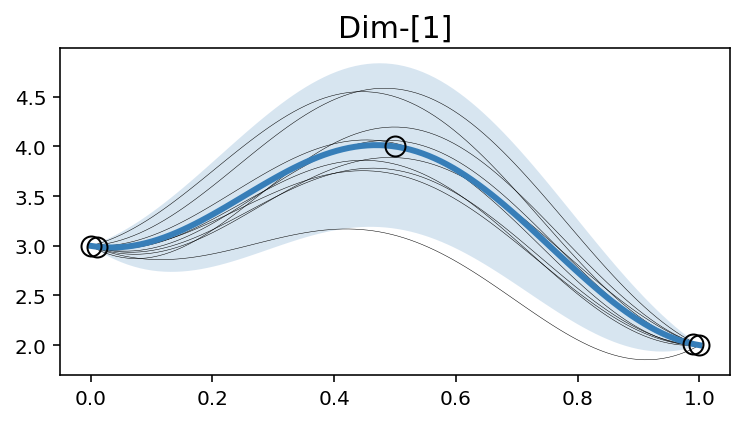

[LGRP] ready.


In [8]:
G = GaussianRandomPathClass(name = 'LGRP',kernel = kernel_levse)
G.set_data(t_anchor    = np.linspace(start=0.0,stop=1.0,num=3).reshape((-1,1)),
           x_anchor    = np.array([[1,1,5],[3,4,2]]).T,
           l_anchor    = np.array([[1,0.5,1]]).T,
           t_test      = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
           l_test      = np.ones((100,1)),
           hyp_mean    = {'g':1.0,'l':0.5,'w':1e-6},
           hyp_var     = {'g':1.0,'l':0.5,'w':1e-6},
           APPLY_EPSRU = True,
           t_eps       = 1e-2
          )
G.plot(n_sample=10)
print ("[%s] ready."%(G.name))

### GRP sampling

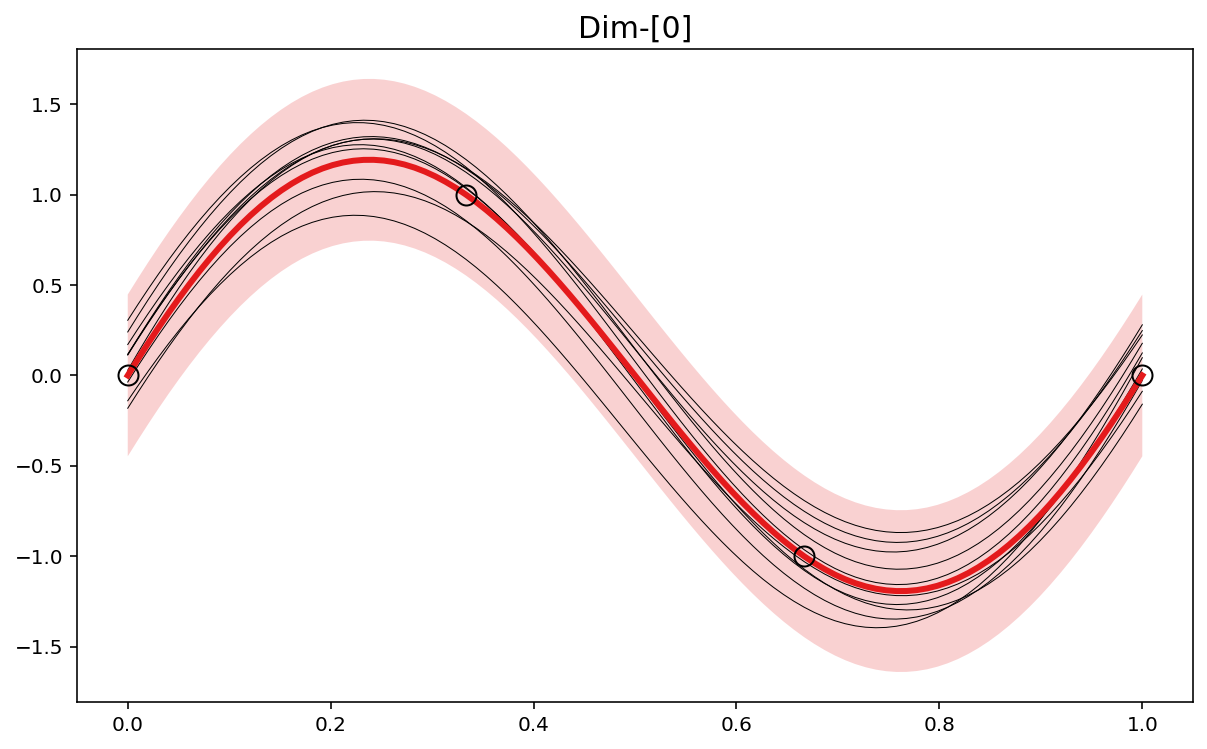

[LGRP] ready.


In [9]:
G = GaussianRandomPathClass(name = 'LGRP',kernel = kernel_levse)
G.set_data(t_anchor     = np.linspace(start=0.0,stop=1.0,num=4).reshape((-1,1)),
           x_anchor     = np.array([[0,1,-1,0]]).T,
           l_anchor     = np.array([[0.5,0.5,0.5,0.5]]).T,
           t_test       = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
           l_test       = np.ones((100,1)),
           hyp_mean     = {'g':1,'l':1/2,'w':1e-8},
           hyp_var      = {'g':1/10,'l':1/2,'w':1e-8},
           w_chol       = 1e-10,
           APPLY_EPSRU  = False,
           x_diff_start = np.array([[-4]]),
           x_diff_end   = np.array([[-4]]),
           t_eps        = 1e-2,
           l_eps        = 1.0
          )
G.plot(n_sample  = 10,
       figsize   = (10,6),
       lw_sample = 1/2)
print ("[%s] ready."%(G.name))

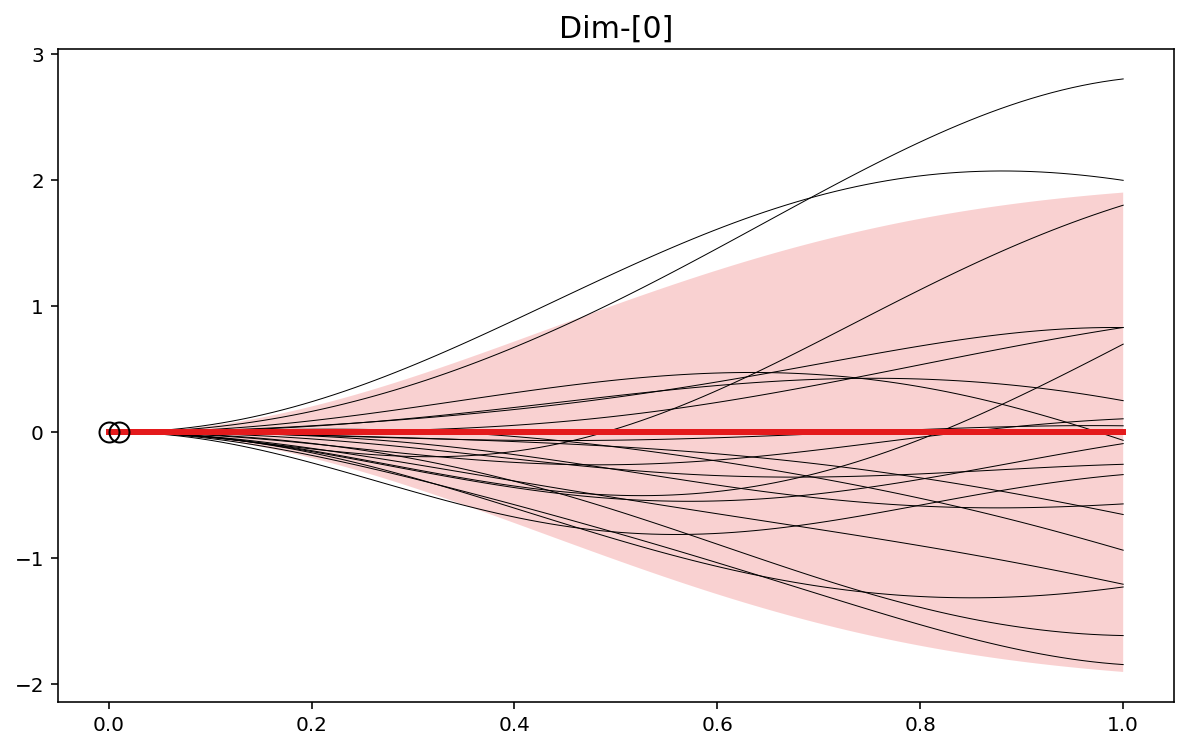

[LGRP] ready.


In [10]:
G = GaussianRandomPathClass(name = 'LGRP',kernel = kernel_levse)
G.set_data(t_anchor     = np.linspace(start=0.0,stop=0.01,num=2).reshape((-1,1)),
           x_anchor     = np.array([[0,0]]).T,
           l_anchor     = np.array([[1,1]]).T,
           t_test       = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
           l_test       = np.ones((100,1)),
           hyp_mean     = {'g':1,'l':1/5,'w':1e-8},
           hyp_var      = {'g':1,'l':1/2,'w':1e-8},
           w_chol       = 1e-10
          )
G.plot(n_sample  = 20,
       figsize   = (10,6),
       lw_sample = 1/2)
print ("[%s] ready."%(G.name))

### Sample a trajectory and get corresponding anchors

In [11]:
def get_anchors_from_traj(t_test,traj,n_anchor=6):
    """
    Get equidist anchors from a trajectory
    """
    n_test = len(t_test)
    idxs = np.round(np.linspace(start=0,stop=n_test-1,num=n_anchor)).astype(np.int16)
    t_anchor,x_anchor = t_test[idxs],traj[idxs]
    return t_anchor,x_anchor

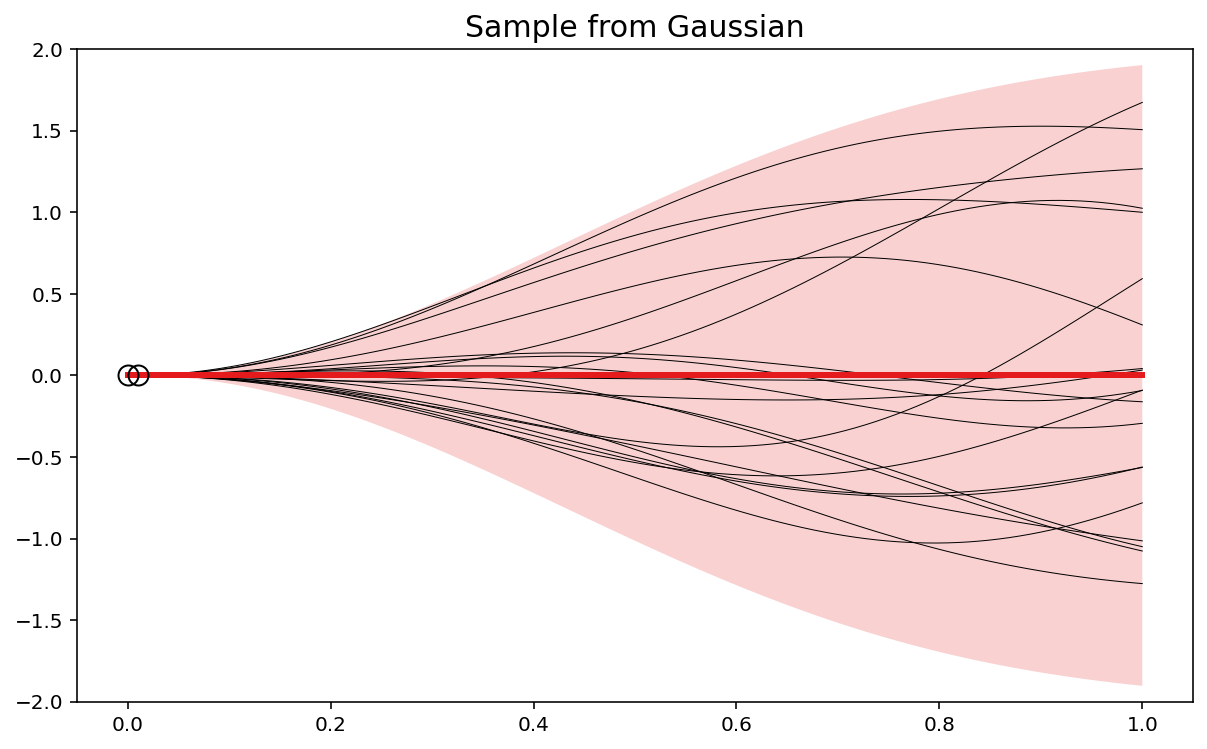

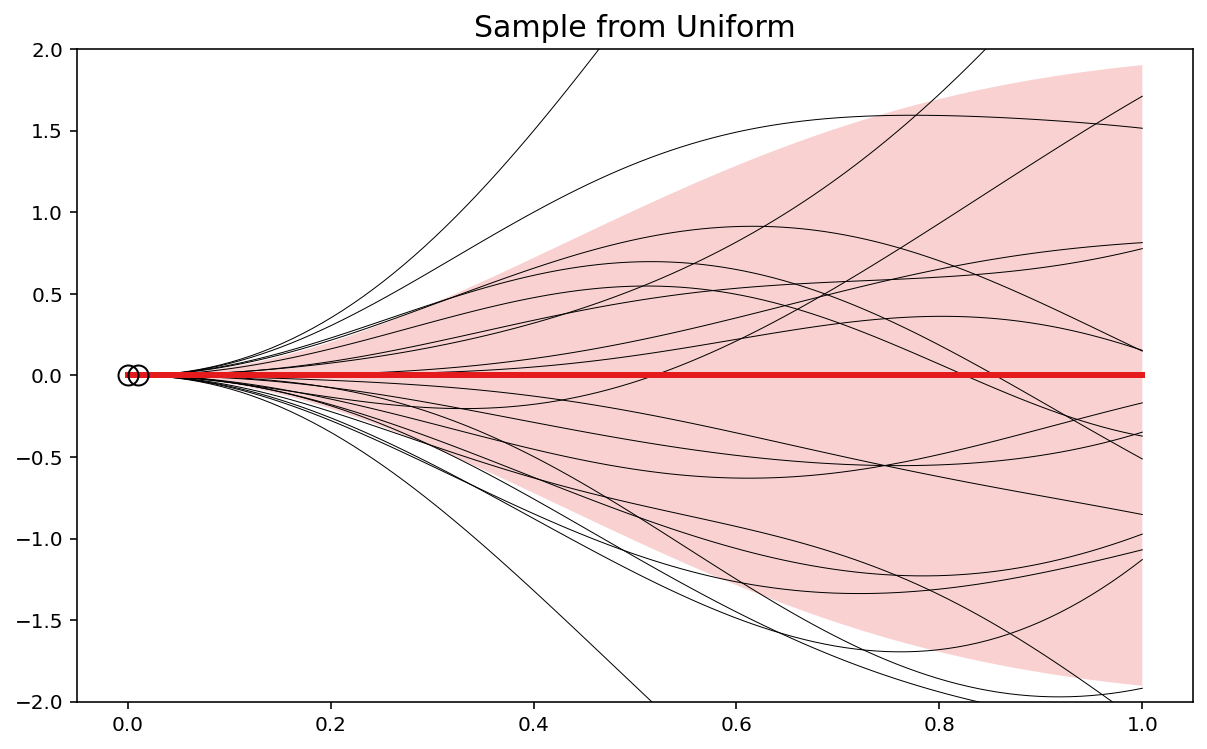

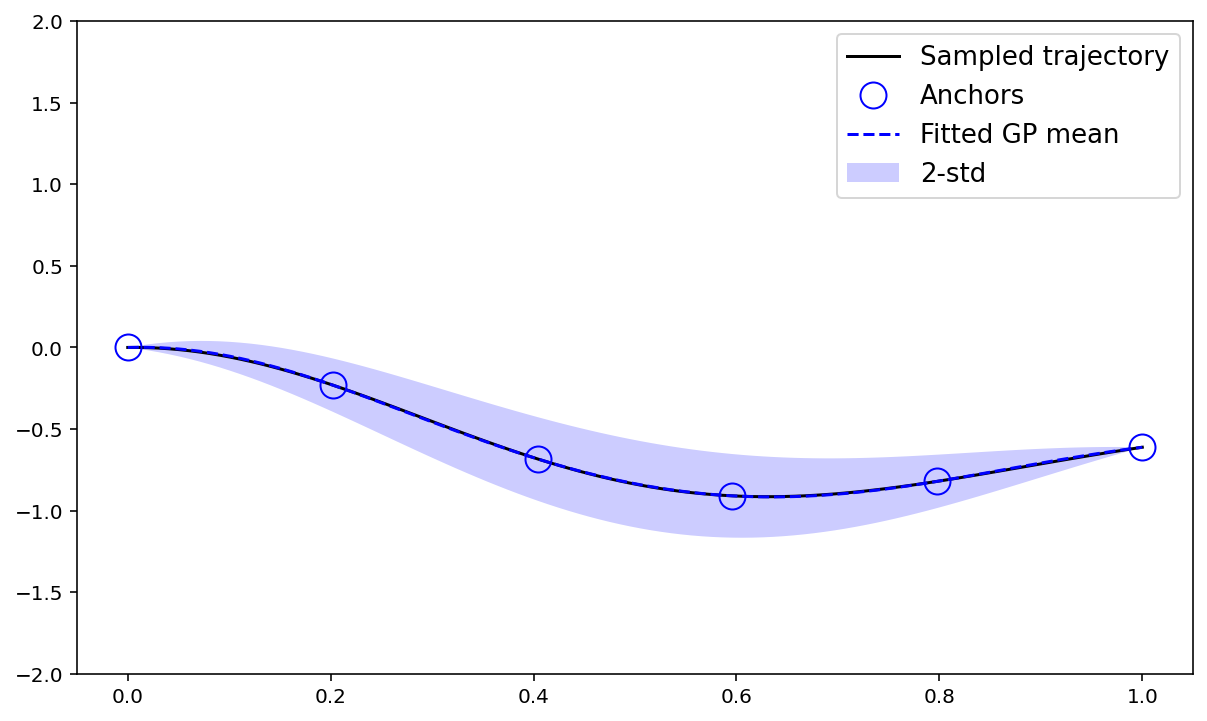

In [12]:
# Sample and get anchors
trajs,t_test = G.sample(n_sample=1)
traj = trajs[0]
n_anchor = 6 # number of anchors
t_anchor,x_anchor = get_anchors_from_traj(t_test,traj,n_anchor=6)
# Define another GRP with the anchor
H = GaussianRandomPathClass(name = 'GPR_anchor',kernel = kernel_levse)
H.set_data(t_anchor     = t_anchor,
           x_anchor     = x_anchor,
           l_anchor     = np.array([[1,1/2,1/2,1/2,1/2,1]]).T,
           t_test       = t_test,
           l_test       = np.ones((len(t_test),1)),
           hyp_mean     = {'g':1,'l':1/5,'w':1e-8},
           hyp_var      = {'g':1/10,'l':1/2,'w':1e-8},
           w_chol       = 1e-10
          )
# Plot
G.plot(n_sample  = 20,
       figsize   = (10,6),
       lw_sample = 1/2,
       rand_type = 'Gaussian',
       ylim      = (-2,+2),
       title_str = 'Sample from Gaussian')
# Plot
G.plot(n_sample  = 20,
       figsize   = (10,6),
       lw_sample = 1/2,
       rand_type = 'Uniform',
       ylim      = (-2,+2),
       title_str = 'Sample from Uniform')
# Plot
plt.figure(figsize=(10,6))
plt.plot(t_test,traj,'-',color='k',label='Sampled trajectory')
plt.plot(t_anchor,x_anchor,'o',ms=13,mfc='none',mec='b',label='Anchors')
plt.plot(t_test,H.mean_test,'--',color='b',label='Fitted GP mean')
plt.fill_between(H.t_test.squeeze(),
                 H.mean_test[:,0]-2*H.std_diag_test.squeeze(),
                 H.mean_test[:,0]+2*H.std_diag_test.squeeze(),
                 facecolor='b',interpolate=True,alpha=0.2,label='2-std') # 2std
plt.legend(fontsize=13)
plt.ylim((-2.0,+2.0))
plt.show()

### Apply Squashing to the sampled trajectories

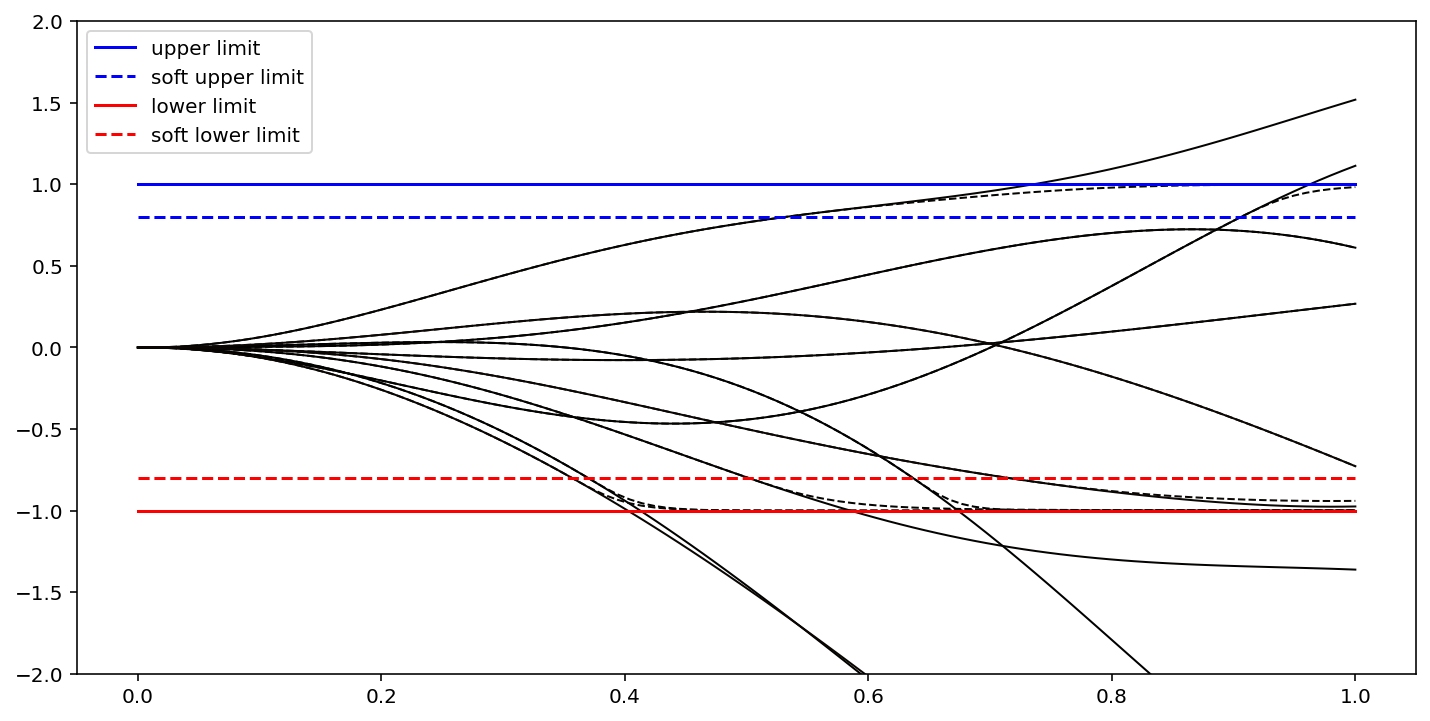

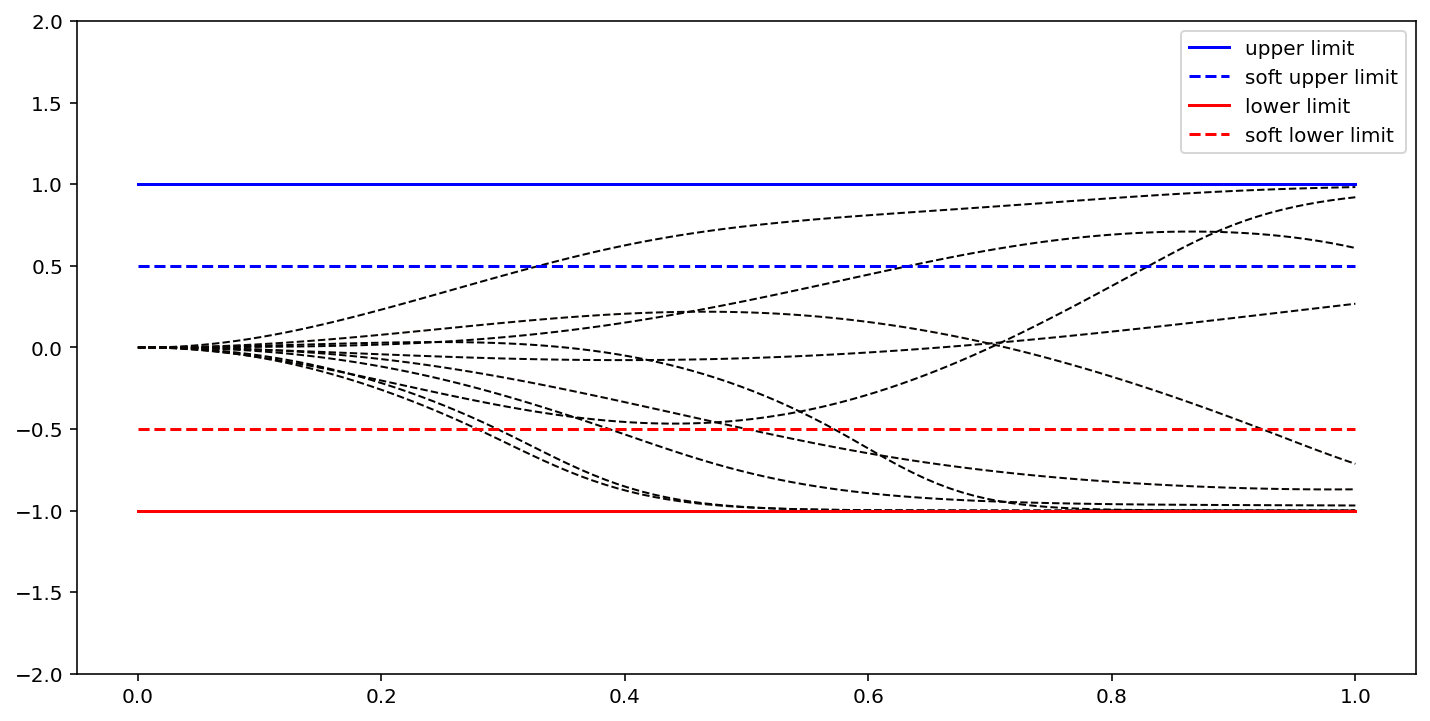

In [13]:
# Sample and get anchors
n_sample = 10
trajs,t_test = G.sample(n_sample=n_sample,rand_type='Uniform')
# Plot
plt.figure(figsize=(12,6))
colors = [plt.cm.copper(i) for i in range(n_sample)]
for t_idx,traj in enumerate(trajs):
    color = colors[t_idx]
    x_min,x_max,margin = -1,1,0.2
    traj_squashed = soft_squash(traj,x_min=x_min,x_max=x_max,margin=margin)
    plt.plot(t_test,traj,'-',color=color,lw=1.0)
    plt.plot(t_test,traj_squashed,'--',color=color,lw=1.0)
plt.plot(t,x_max*np.ones_like(t),color='b',label='upper limit')
plt.plot(t,(x_max-margin)*np.ones_like(t),'--',color='b',label='soft upper limit')
plt.plot(t,x_min*np.ones_like(t),'-',color='r',label='lower limit')
plt.plot(t,(x_min+margin)*np.ones_like(t),'--',color='r',label='soft lower limit')
plt.legend(fontsize=10)
plt.ylim((-2.0,+2.0))
plt.show()

plt.figure(figsize=(12,6))
colors = [plt.cm.copper(i) for i in range(n_sample)]
for t_idx,traj in enumerate(trajs):
    color = colors[t_idx]
    x_min,x_max,margin = -1,1,0.5
    traj_squashed = soft_squash(traj,x_min=x_min,x_max=x_max,margin=margin)
    # plt.plot(t_test,traj,'-',color=color,lw=1.0)
    plt.plot(t_test,traj_squashed,'--',color=color,lw=1.0)
plt.plot(t,x_max*np.ones_like(t),color='b',label='upper limit')
plt.plot(t,(x_max-margin)*np.ones_like(t),'--',color='b',label='soft upper limit')
plt.plot(t,x_min*np.ones_like(t),'-',color='r',label='lower limit')
plt.plot(t,(x_min+margin)*np.ones_like(t),'--',color='r',label='soft lower limit')
plt.legend(fontsize=10)
plt.ylim((-2.0,+2.0))
plt.show()